<a href="https://www.kaggle.com/code/sakibsrizon/sf-salary-stats-eda?scriptVersionId=109448245" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# <div style="text-align:center; border-style:solid; background-color:#e6faff; padding: 20px;line-height:1; border-radius:20px;">**SF Salary Model EDA**
</div>
 <h3 style = "text-decoration-line:underline;">Preprocessing</h3> 
 <ul style = " line-style-type: circle">
    <li>Detect continuous and categorical variables.</li>
    <li>Normalize and impute data.</li>
 </ul>
<h3 style = "text-decoration-line:underline;">For every target variable in the dataset</h3> 
 <ul style = " line-style-type: circle">
    <li>Compare performance on 27 models + a TabNet model.</li>
    <li>Normalize and impute data.</li>
    <li>Save plots + CSVs of XGBoost Feature Importances.</li>
    <li>Save best performing FastAI model.</li>
 </ul>


In [1]:
# Installing essential libs
!pip install lazypredict fast-tabnet fastai pandas-profiling

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.8/41.8 kB 1.1 MB/s eta 0:00:00
  Attempting uninstall: typing-extensions
    Found existing installation: typing_extensions 4.4.0
    Uninstalling typing_extensions-4.4.0:
      Successfully uninstalled typing_extensions-4.4.0
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 2.1.1
    Uninstalling MarkupSafe-2.1.1:
      Successfully uninstalled MarkupSafe-2.1.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-io 0.21.0 requires tensorflow-io-gcs-filesystem==0.21.0, which is not installed.
beatrix-jupyterlab 3.1.7 requires google-cloud-bigquery-storage, which is not installed.
werkzeug 2.2.2 requires MarkupSafe>=2.1.1, but you have markupsafe 2.0.1 which is incompatible.
tensorflow 2.6.4 requires h5py~=3.1.0, but you have h5py 3.7.0 which is incompatible.
tensorflow 2.6.4 r

In [2]:
# importing basic libs
import numpy as np 
import pandas as pd 
import pandas_profiling 

# LazyPredict
import lazypredict
from lazypredict.Supervised import LazyRegressor
from lazypredict.Supervised import LazyClassifier

# Baysian Optimization
from bayes_opt import BayesianOptimization

# FastAI
from fastai.tabular.all import *
from fastai.tabular.core import *
from fast_tabnet.core import *

# Plots
import matplotlib.pyplot as plt
import seaborn as sns

# System
import os,sys,traceback

# Fit for Xgboost model
from xgboost import XGBRegressor,XGBClassifier,plot_importance
from sklearn.metrics import mean_squared_error,roc_auc_score

# Random
import random

import shutil
%matplotlib inline
plt.style.use('seaborn-bright')
print("All Lib imported")

All Lib imported


### Definifng project Variables

In [3]:
PROJECT_NAME = 'sanfrancisco-salary-3-years'
VARIABLE_FIELS =False

# Maximum row amount 
SAMPLE_COUNT = 2000
FASTAI_LEARNING_RATE = 1e-1
AUTO_ADJUEST_LEARNING_RATE = False

# Set to true automatically infer if variables are categorical or continuous
Enable_BREAKPOINTS = True 

# When trying to declear a column a continuous variable, if it's not it'll convert to categorical variables
CONVERT_TO_CAT = False 
REGRESSOR = True 
SEP_DOLLER = False 
SEP_COMMA = False
SHUFFLE_DATA = True


In [4]:
# importing Data set 
input_dir = f'../input/{PROJECT_NAME}'
param_dir = f'/kaggle/working/{PROJECT_NAME}'
TARGET = ''
PARAM_DIR = param_dir
print(f'param_dir: {param_dir}')
if not os.path.exists(param_dir):
    os.makedirs(param_dir)
df = pd.read_csv('../input/sanfrancisco-salary-3-years/SanFrancisco_salary (csv).csv', nrows=SAMPLE_COUNT)
df.head(10)

param_dir: /kaggle/working/sanfrancisco-salary-3-years


,Unnamed: 0,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Department,Department_ML
0,36159,36160,Gary Altenberg,"Lieutenant, Fire Suppression",128808.87,220909.48,13126.31,44430.12,362844.66,407274.78,2012,Fire,4
1,36160,36161,Gregory Suhr,Chief of Police,302578.00,0.00,18974.11,69810.19,321552.11,391362.30,2012,Other,2
2,36161,36162,Khoa Trinh,Electronic Maintenance Tech,111921.00,146415.32,78057.41,53102.29,336393.73,389496.02,2012,Not dep,5
3,36162,36163,Joanne Hayes-White,"Chief, Fire Department",296943.01,0.00,17816.59,72047.88,314759.60,386807.48,2012,Other,2
4,36163,36164,Frederick Binkley,EMT/Paramedic/Firefighter,126863.19,192424.49,17917.18,44438.25,337204.86,381643.11,2012,Other,2
5,36164,36165,Amy Hart,Dept Head V,271607.74,0.00,19782.03,84681.82,291389.77,376071.59,2012,Medicine,3
6,36165,36166,Edward Reiskin,"Gen Mgr, Public Trnsp Dept",294000.17,0.00,0.00,82001.94,294000.17,376002.11,2012,Other,2
7,36166,36167,John Martin,Dept Head V,287747.89,0.00,5274.57,81824.37,293022.46,374846.83,2012,Medicine,3
8,36167,36168,John Goldberg,Captain 3,104404.00,0.00,245999.41,24287.23,350403.41,374690.64,2012,Fire,4
9,36168,36169,David Franklin,Asst Chf of Dept (Fire Dept),204032.52,85503.16,26193.09,58486.10,315728.77,374214.87,2012,Fire,4


In [5]:
# Replacing Doller sign in every columns 
if SEP_DOLLER:
    for  col in df.columns:
        if '$' in df[col].to_string():
            df[col + '_no_dollar'] = df[col].str.replace('$', '').str.replace(',', '')
            try:
                df[col + '_no_dollar'] = df[col + '_no_dollar'].apply(pd.to_numeric, errors = 'coerce').dropna()
            except:
                print(f'{col} can not be converted to float!')
                
if SEP_COMMA:
    for col in df.columns:
        if '%' in df[col].to_string() or ',' in df[col].to_string():
            df[col + '_processed'] = df[col].str/replace('%', '').str.replace(',','')
#             Trying to convert this new column  to a numeric type 
            try:
                df[col + '_processed'] = df[col + '_processed'].apply(pd.to_numeric, errors = 'coerce').dropna()
            except:
                print(f'{col} can not be converted to a float!')
                
# Shwoing Modified dataframe
df.head(10)

,Unnamed: 0,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Department,Department_ML
0,36159,36160,Gary Altenberg,"Lieutenant, Fire Suppression",128808.87,220909.48,13126.31,44430.12,362844.66,407274.78,2012,Fire,4
1,36160,36161,Gregory Suhr,Chief of Police,302578.00,0.00,18974.11,69810.19,321552.11,391362.30,2012,Other,2
2,36161,36162,Khoa Trinh,Electronic Maintenance Tech,111921.00,146415.32,78057.41,53102.29,336393.73,389496.02,2012,Not dep,5
3,36162,36163,Joanne Hayes-White,"Chief, Fire Department",296943.01,0.00,17816.59,72047.88,314759.60,386807.48,2012,Other,2
4,36163,36164,Frederick Binkley,EMT/Paramedic/Firefighter,126863.19,192424.49,17917.18,44438.25,337204.86,381643.11,2012,Other,2
5,36164,36165,Amy Hart,Dept Head V,271607.74,0.00,19782.03,84681.82,291389.77,376071.59,2012,Medicine,3
6,36165,36166,Edward Reiskin,"Gen Mgr, Public Trnsp Dept",294000.17,0.00,0.00,82001.94,294000.17,376002.11,2012,Other,2
7,36166,36167,John Martin,Dept Head V,287747.89,0.00,5274.57,81824.37,293022.46,374846.83,2012,Medicine,3
8,36167,36168,John Goldberg,Captain 3,104404.00,0.00,245999.41,24287.23,350403.41,374690.64,2012,Fire,4
9,36168,36169,David Franklin,Asst Chf of Dept (Fire Dept),204032.52,85503.16,26193.09,58486.10,315728.77,374214.87,2012,Fire,4


In [6]:
df.isna().sum()

Unnamed: 0          0
Id                  0
EmployeeName        0
JobTitle            0
BasePay             0
OvertimePay         0
OtherPay            0
Benefits            0
TotalPay            0
TotalPayBenefits    0
Year                0
Department          0
Department_ML       0
dtype: int64

In [7]:
# df.profile_report()

<AxesSubplot:>

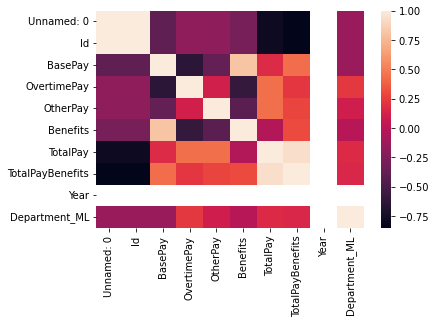

In [8]:
sns.heatmap(df.corr())

In [9]:
df.head().style.background_gradient(cmap = "inferno")

,Unnamed: 0,Id,EmployeeName,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Department,Department_ML
0,36159,36160,Gary Altenberg,"Lieutenant, Fire Suppression",128808.87,220909.48,13126.31,44430.12,362844.66,407274.78,2012,Fire,4
1,36160,36161,Gregory Suhr,Chief of Police,302578.00,0.00,18974.11,69810.19,321552.11,391362.30,2012,Other,2
2,36161,36162,Khoa Trinh,Electronic Maintenance Tech,111921.00,146415.32,78057.41,53102.29,336393.73,389496.02,2012,Not dep,5
3,36162,36163,Joanne Hayes-White,"Chief, Fire Department",296943.01,0.00,17816.59,72047.88,314759.60,386807.48,2012,Other,2
4,36163,36164,Frederick Binkley,EMT/Paramedic/Firefighter,126863.19,192424.49,17917.18,44438.25,337204.86,381643.11,2012,Other,2


In [10]:
df.describe().T.style.background_gradient(cmap = "viridis")

,count,mean,std,min,25%,50%,75%,max
Unnamed: 0,2000.00,37158.50,577.49,36159.00,36658.75,37158.50,37658.25,38158.00
Id,2000.00,37159.50,577.49,36160.00,36659.75,37159.50,37659.25,38159.00
BasePay,2000.00,148195.29,31520.30,15158.50,127422.00,146318.59,168107.32,302578.00
OvertimePay,2000.00,23828.70,30083.39,0.00,0.00,7705.68,44185.85,220909.48
OtherPay,2000.00,14687.21,20616.31,0.00,3486.00,11639.35,18651.31,245999.41
Benefits,2000.00,48423.04,9763.97,14074.28,39968.58,47454.85,55939.85,84681.82
TotalPay,2000.00,186711.19,27667.63,145326.61,168462.37,179515.78,196784.94,362844.66
TotalPayBenefits,2000.00,235134.23,28961.98,205119.21,214971.90,226618.20,245249.80,407274.78
Year,2000.00,2012.00,0.00,2012.00,2012.00,2012.00,2012.00,2012.00
Department_ML,2000.00,2.52,1.26,1.00,1.00,2.00,4.00,5.00


In [11]:
# Shwoing columns
df.columns

Index(['Unnamed: 0', 'Id', 'EmployeeName', 'JobTitle', 'BasePay',
       'OvertimePay', 'OtherPay', 'Benefits', 'TotalPay', 'TotalPayBenefits',
       'Year', 'Department', 'Department_ML'],
      dtype='object')

In [12]:
# removing the unnecessary features 
del(df['Unnamed: 0'])
del(df['EmployeeName'])
del(df['Id'])
df.head(10)

,JobTitle,BasePay,OvertimePay,OtherPay,Benefits,TotalPay,TotalPayBenefits,Year,Department,Department_ML
0,"Lieutenant, Fire Suppression",128808.87,220909.48,13126.31,44430.12,362844.66,407274.78,2012,Fire,4
1,Chief of Police,302578.00,0.00,18974.11,69810.19,321552.11,391362.30,2012,Other,2
2,Electronic Maintenance Tech,111921.00,146415.32,78057.41,53102.29,336393.73,389496.02,2012,Not dep,5
3,"Chief, Fire Department",296943.01,0.00,17816.59,72047.88,314759.60,386807.48,2012,Other,2
4,EMT/Paramedic/Firefighter,126863.19,192424.49,17917.18,44438.25,337204.86,381643.11,2012,Other,2
5,Dept Head V,271607.74,0.00,19782.03,84681.82,291389.77,376071.59,2012,Medicine,3
6,"Gen Mgr, Public Trnsp Dept",294000.17,0.00,0.00,82001.94,294000.17,376002.11,2012,Other,2
7,Dept Head V,287747.89,0.00,5274.57,81824.37,293022.46,374846.83,2012,Medicine,3
8,Captain 3,104404.00,0.00,245999.41,24287.23,350403.41,374690.64,2012,Fire,4
9,Asst Chf of Dept (Fire Dept),204032.52,85503.16,26193.09,58486.10,315728.77,374214.87,2012,Fire,4


In [13]:
target = ''
target_str = ''
target = []
# Lopping through every possible target columns 
for i in range(len(df.columns) - 1,0,-1):
    try:
        df[df.columns[i]] = df[df.columns[i]].apply(pd.to_numeric, errors = 'coerce').dropna()
        target = df.columns[i]
        target_str = target.replace('/','-')
    except:
        continue
    print(f'Target Variable : {target}')

Target Variable : Department_ML
Target Variable : Department
Target Variable : Year
Target Variable : TotalPayBenefits
Target Variable : TotalPay
Target Variable : Benefits
Target Variable : OtherPay
Target Variable : OvertimePay
Target Variable : BasePay
